<a href="https://colab.research.google.com/github/jj364/deep_learning/blob/main/Keras_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Conv2DTranspose, Reshape
from keras.optimizers import Adam
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
(train_x, train_y), (test_x, test_y) = load_data()  # Load dataset

11493376/11490434 [==============================] - 0s 0us/step


Get some basic info about dataset

In [3]:
print(f"Train size: {train_x.shape}")
print(f"Test size: {test_x.shape}")
print(f"Number of training samples: {train_x.shape[0]}")
print(f"Number of testing samples: {test_x.shape[0]}")
print(f"Sample dimensions: {train_x.shape[1]} x {train_x.shape[2]} px")

Train size: (60000, 28, 28)
Test size: (10000, 28, 28)
Number of training samples: 60000
Number of testing samples: 10000
Sample dimensions: 28 x 28 px


Plot some samples - title is 'ground truth' label

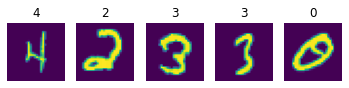

In [4]:
sample_indicies = [random.randint(0, train_x.shape[0]-1) for _ in range(5)]
fig, ax = plt.subplots(1, 5, figsize=(6,2))
for i,a in enumerate(ax):
  a.imshow(train_x[sample_indicies[i]])
  a.axis('off')
  a.set_title(train_y[sample_indicies[i]])  # provide true label
plt.show()

# Time to work on the Generative Adversarial Network (GAN)
Firstly, let's define the descriminator which tries to work out which data is 'real' and which has been generated

In [5]:
def create_discriminator(dims=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), input_shape=dims))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), input_shape=dims))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(lr = 0.0005, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [23]:
def create_generator(latent_dim):
  model = Sequential()
  model.add(Dense(128*24*24, input_dim=latent_dim))
  model.add(Reshape((24, 24, 128)))
  model.add(Conv2DTranspose(128, (3,3)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (3,3)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))
  return model

In [30]:
def create_gan(gen, disc):
  disc.trainable = False
  model = Sequential()
  model.add(gen)
  model.add(disc)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [6]:
def get_real_samples(dset, n):  # get n samples from dataset
  ix = np.random.randint(0, dset.shape[0], n)
  X = dset[ix]
  Y = np.ones((n, 1))  # One label for 'real' samples
  return X, Y

In [38]:
def get_latent_points(latent_dim, n):
  x_input = np.random.randn(latent_dim * n)  # n normally distributed samples
  x_input = x_input.reshape(n, latent_dim)  # reshape to fit latent space
  return x_input

In [33]:
def get_fake_samples(generator, latent_dim, n):
  x_input = get_latent_points(latent_dim, n)
  X = generator.predict(x_input)  # Run through generator
  Y = np.zeros((n, 1))  # Zero label for 'fake' sample
  return X, Y

We need to prepare the data for training

In [8]:
X = np.expand_dims(train_x, axis=-1)  # Even though its b&w image need 3rd channel
X = X.astype('float32')  # Needs to be float for rescaling
X = X / 255.0  # Rescale between 0 and 1

In [40]:
generator = create_generator(100)
discriminator = create_discriminator()
gan = create_gan(generator, model)
gan.summary()

n_epochs = 100
batch_size = 256
bat_per_epoch = int(X.shape[0] / n_epochs)
half_bat = int(batch_size/2)

for i in range(n_epochs):
  for j in range(bat_per_epoch):
    x_real, y_real = get_real_samples(X, half_bat)
    x_fake, y_fake = get_fake_samples(generator, 100, half_bat)
    x_dis, y_dis = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
    dis_loss, _ = discriminator.train_on_batch(x_dis, y_dis)

    x_gan = get_latent_points(100, batch_size)
    y_gan = np.ones((batch_size, 1))  # Need 'inverted' label
    gan_loss = gan.train_on_batch(x_gan, y_gan)
    print(f'Epoch: {i}, Batch:{j}, Discriminator loss: {dis_loss:.3f}, gan loss: {gan_loss:.3f}')

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_21 (Sequential)   (None, 28, 28, 1)         7742849   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 74433     
Total params: 7,817,282
Trainable params: 7,742,849
Non-trainable params: 74,433
_________________________________________________________________
Epoch: 0, Batch:0, Discriminator loss: 0.6792196035385132, gan loss: 5.7091827392578125
Epoch: 0, Batch:1, Discriminator loss: 0.6021277904510498, gan loss: 5.627144813537598
Epoch: 0, Batch:2, Discriminator loss: 0.5291271805763245, gan loss: 5.49466609954834
Epoch: 0, Batch:3, Discriminator loss: 0.4624885022640228, gan loss: 5.394031524658203
Epoch: 0, Batch:4, Discriminator loss: 0.37608563899993896, gan loss: 5.222455978393555
Epoch: 0, Batch:5, Discriminator loss: 0.2804625630378723, gan l

KeyboardInterrupt: ignored